<a href="https://colab.research.google.com/github/tiago121/health_insurance_classification_project/blob/main/Health_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Insurance Cross Sell

## 0.0 Initial considerations

In [ ]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 0.1 Imports

In [ ]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
import xgboost    as xgb

### 0.2 Helper functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()


def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    #data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# In classification tasks with imbalanced class distributions we should prefer stratifiedkfold over kfold, because the class distributions is preserved in the splits.
#def cross_validation(data, models_performance, num_folds, modelName, model, x_train, y_train, k):
def cross_validation(data, num_folds, modelName, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    #f1_score_list = []
    #roc_list = []
    
    i = 1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3).astype(str)
    # there are others ranking metrics like F1-Score and Average precision but little used.
    
        
    #models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    #return models_performance
    return {'Model Name': modelName, 'Precision_at_k': precision_str, 'Recall_at_k': recall_str}

## 1.0 Data Description

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Data Science/Datasets Notebooks/health_insurance.csv')
df1 = df1.rename(columns=str.lower)
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:


aux1 = df1['gender']
aux2 = df1['vehicle_damage']
aux3 = df1['vehicle_age']
aux4 = df1['policy_sales_channel']

list = [aux1 , aux2 , aux3, aux4 ]

for i in list:
    df1_counts = i.value_counts(normalize=True)
    display(df1_counts)




Male      0.540761
Female    0.459239
Name: gender, dtype: float64

Yes    0.504877
No     0.495123
Name: vehicle_damage, dtype: float64

1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: vehicle_age, dtype: float64

152.0    0.353663
26.0     0.209127
124.0    0.194157
160.0    0.057146
156.0    0.027974
           ...   
149.0    0.000003
43.0     0.000003
144.0    0.000003
143.0    0.000003
41.0     0.000003
Name: policy_sales_channel, Length: 155, dtype: float64

### 1.1 Check NA / Duplicates

In [ ]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [ ]:
print(f"df has {df1.duplicated().sum()} duplicated data")

df has 0 duplicated data


### 1.2 Informações colhidas com descrição

1. Não há dados faltantes
2. Age tem dados como float
3. Não há variáveis textos
4. Encodar gender para 0 e 1
5. Encodar Vehicle_Age e Vehicle_Damage

## 2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_Year' )

##3.0 EDA (Exploratory Data Analysis) 

In [ ]:
df3 = df2.copy()
num_attributes = df3.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
9,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [ ]:
#num_var = ["age", "annual_premium", "vintage"]
#cat_var = ["gender", "region_code", "previously_insured", "vehicle_age", "vehicle_damage","policy_sales_channel" ]
#target = "response"

### 3.1 Univariate Analysis

#### 3.1.1 Age

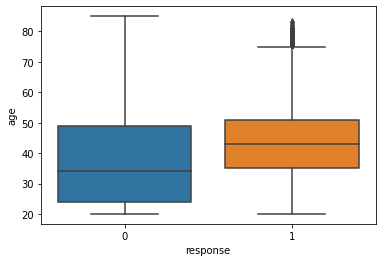

In [ ]:
sns.boxplot( x='response', y='age', data=df3 )


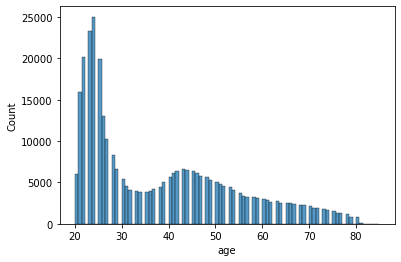

In [ ]:
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot( aux00 )

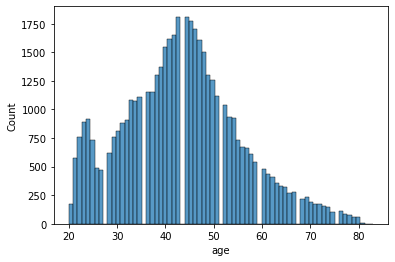

In [ ]:
aux00 = df3.loc[df3['response'] == 1, 'age']
sns.histplot( aux00 )

#### 3.1.2 Anual Income

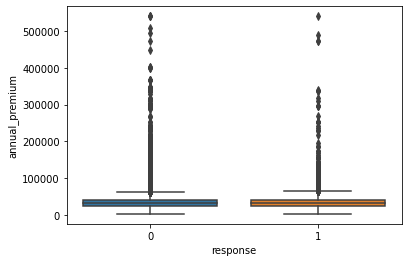

In [ ]:
sns.boxplot( x='response', y='annual_premium', data=df3 )

In [ ]:
df3 = df3[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 100000)]

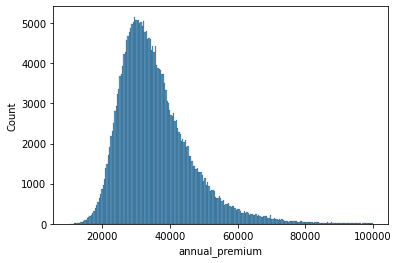

In [ ]:
aux00 = df3.loc[df3['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

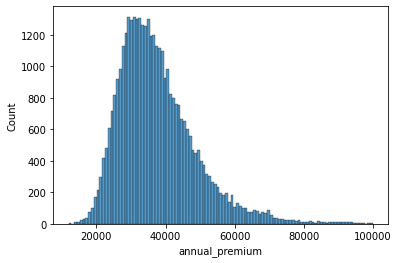

In [ ]:
aux00 = df3.loc[df3['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

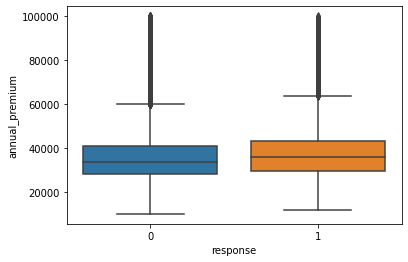

In [ ]:
sns.boxplot( x='response', y='annual_premium', data=df3 )

#### 3.1.3 Driving License

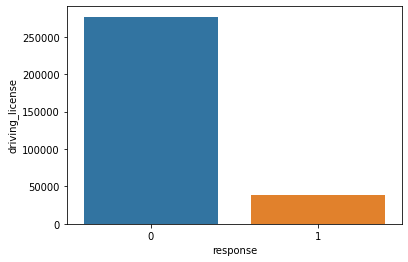

In [ ]:
aux = df3[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )

#### 3.1.4 Region Code

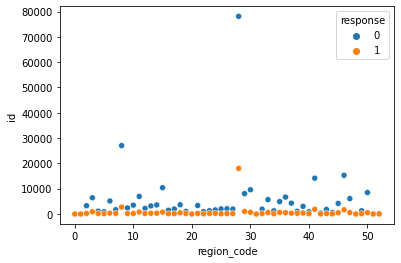

In [ ]:
aux0 = df3[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

#### 3.1.5 Previously Insured

In [ ]:
pd.crosstab(df3['previously_insured'], df3['response'] ).apply( lambda x: x / x.sum(), axis=1 )


response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


#### 3.1.6 Vehicle Age

In [ ]:
df3[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()


,vehicle_age,response,id
0,below_1_Year,0,137861
1,below_1_Year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


#### 3.1.7 Vehicle Damage

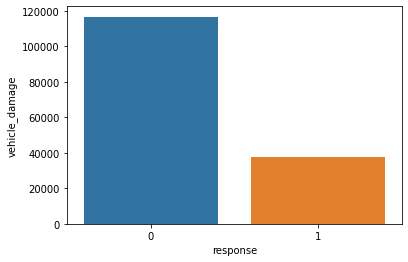

In [ ]:
aux = df3[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

#### 3.1.8 Policy Sales Channel 


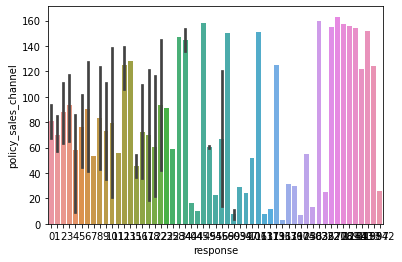

In [ ]:
aux = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [ ]:
aux01 = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df3[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2
...,...,...,...
143,157.0,706,2353
144,158.0,45,148
145,159.0,1,21
146,160.0,303,16225


#### 3.1.9 Vintage

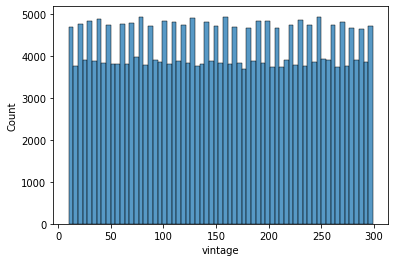

In [ ]:
aux = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot( aux )

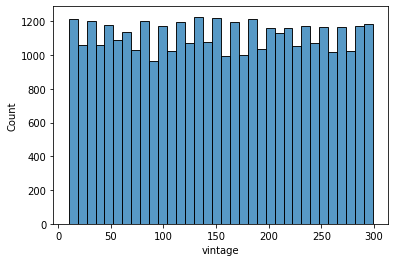

In [ ]:
aux = df3.loc[df3['response'] == 1, 'vintage']
sns.histplot( aux )

In [ ]:
df = pd.pivot_table( index='vintage', columns='response', values='id', data=df3).reset_index()
df.columns = ['vintage', 'no_response', 'yes_response']

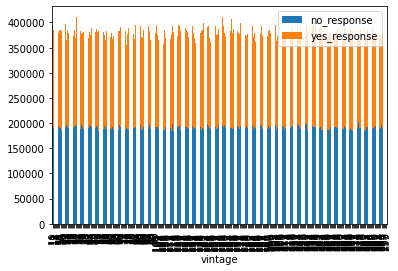

In [ ]:
df.plot( x='vintage', kind='bar', stacked=True)

### 3.2 Bivariate Analysis

H1: Women are more likely to purchase car insurance.

The hypothesis is FALSE, the interest among men is greater.

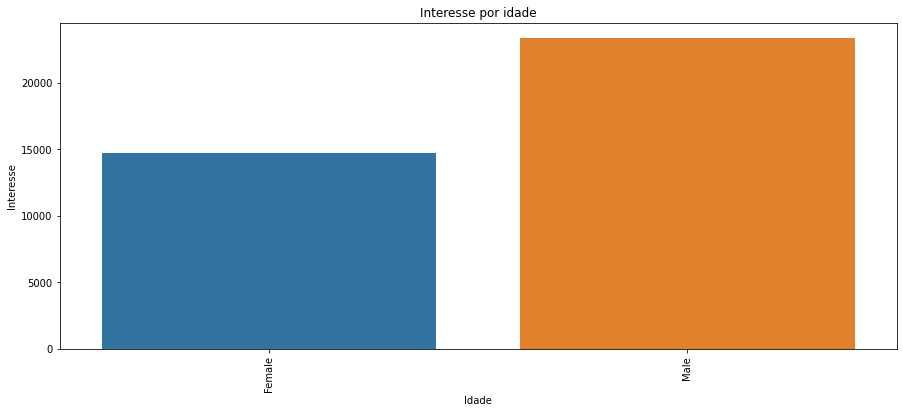

In [ ]:
# Analyse just interested customers by age
plt.figure(figsize=(15,6))
aux_age2 = df3[['gender', 'response']].groupby('gender').sum().reset_index()
eda_age2 = sns.barplot( x='gender', y='response', data=aux_age2 )
eda_age2.set_title('Interesse por idade')
eda_age2.set_xlabel('Idade')
eda_age2.set_ylabel('Interesse')
plt.xticks( rotation=90 );

H2: The greater the age, the greater the possibility of taking out auto insurance.

The hypothesis is false.

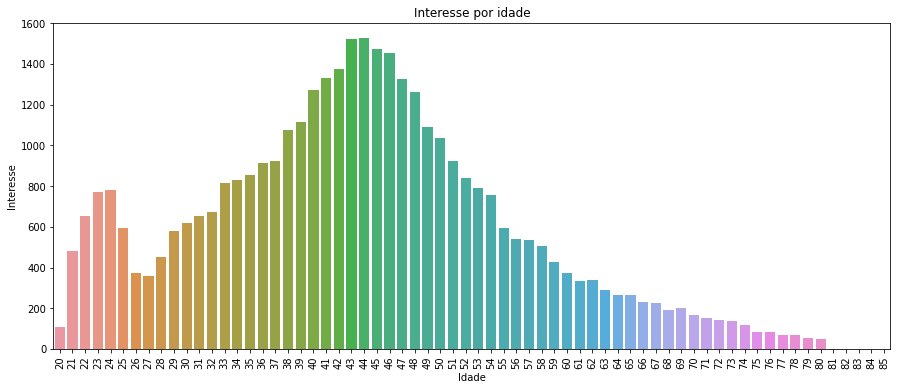

In [ ]:
# Analyse just interested customers by age
plt.figure(figsize=(15,6))
aux_age2 = df3[['age', 'response']].groupby('age').sum().reset_index()
eda_age2 = sns.barplot( x='age', y='response', data=aux_age2 )
eda_age2.set_title('Interesse por idade')
eda_age2.set_xlabel('Idade')
eda_age2.set_ylabel('Interesse')
plt.xticks( rotation=90 );

H3: Residence influences the decision to take out auto insurance.

The hypothesis is TRUE. Some regions have a higher concentration of auto insurance interests.

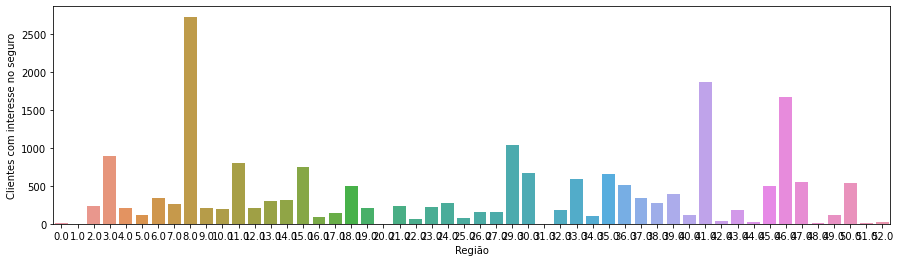

In [ ]:
aux = df3[(df3['region_code'] != 28) & (df3['response'] == 1)]
fig3 = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);
plt.xlabel("Região")
plt.ylabel("Clientes com interesse no seguro")
plt.show(fig3)

H4: People who have had damage to their car are more likely to take out car insurance.

The hypothesis is TRUE. When car damage occurred, there is car insurance interest.

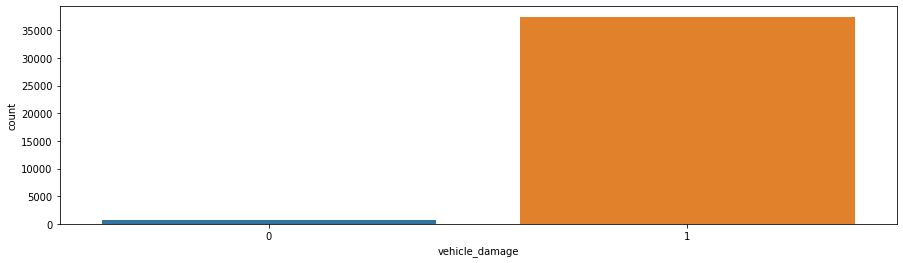

In [ ]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'vehicle_damage', data = df3[df3['response'] == 1]);


H5: Customers with higher health insurance expenses are more likely to purchase a new product.

The hypothesis is FALSE. There is a concentration of positive answers around of mean of annual premiums paid.

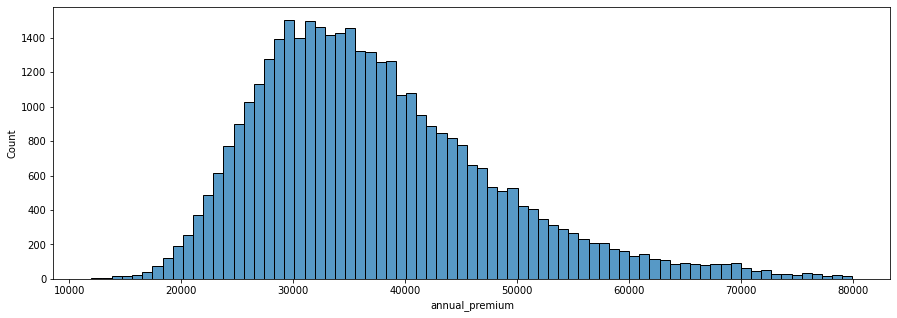

In [ ]:
# annual_premium
h5 = df3.loc[(df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000)]
h5 = h5.loc[h5['response'] == 1, 'annual_premium']

fig = plt.subplots(figsize = (15,5))
sns.histplot(h5, bins = 75);

### 3.3 Insights

1. Idade dos clientes com mais propensão se concentra entre 40 a 50 anos.
2. Região é um fator importante para explicar interesse
3. Pessoas com gastos com seguro maior não necessariamente têm mais chance de comprar um novo seguro

Esses insights são importantes para a abordagem do time de vendas e para a escolha da melhor estratégia de seleção de features.

## 4.0 Data Preparation



In [ ]:
X = df3.drop( 'response', axis=1 )
y = df3['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size= 0.20 )

df4 = pd.concat( [x_train, y_train], axis=1 )

### 4.1 Standardization

In [ ]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )


### 4.2. Reescaling

In [ ]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df4['age'] = mms_age.fit_transform( df4[['age']].values )


# Vintage - MinMaxScaler
df4['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )


### 4.3 Encoding

In [ ]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df4.groupby( 'gender' )['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encode_gender )


# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df4.groupby( 'region_code' )['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df4.groupby( 'policy_sales_channel' ).size() / len( df4 ) 
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( fe_policy_sales_channel )


### 4.4 Validation Preparation

In [ ]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

## 5.0 Feature Selection

In [ ]:
df5 = df4.copy()

In [ ]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()


In [ ]:
# Define model
#et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
#boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

In [ ]:
#cols_selected = boruta.support_.tolist()

# best features
#x_train_fs = df5.drop( ['id', 'response'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta
# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [ ]:
# model definition
#forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
#x_train_n = df5.drop( ['id', 'response'], axis=1 )
#y_train_n = y_train.values
#forest.fit( x_train_n, y_train_n )

In [ ]:
#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
##indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
#df = pd.DataFrame()
#for i, j in zip( x_train_n, forest.feature_importances_ ):
#    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
 #   df = pd.concat( [df, aux], axis=0 )
    
#print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
#plt.xticks(range(x_train_n.shape[1]), indices)
#plt.xlim([-1, x_train_n.shape[1]])
#plt.show()

## 6.0 Machine Learning Modelling


In [ ]:
df6 = df5.copy()

In [ ]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 
                 'vehicle_damage','previously_insured']

In [ ]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

### 6.1 KNN Classifier


In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

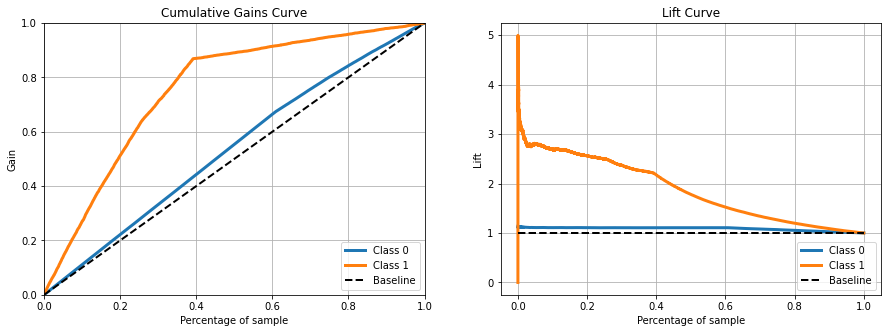

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax = axs[0])

# Lift
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax = axs[1]);

In [ ]:
# Performance
# compute precision at k
knn_precision_at_k = round(precision_at_k(df6, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Precision at K: {}'.format(knn_precision_at_k))

# compute Recall at k
knn_recall_at_k = round(recall_at_k(df6, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Recall at K: {}'.format(knn_recall_at_k))

KNN Model - Precision at K: 0.264
KNN Model - Recall at K: 0.87


#### 6.1.1 KNN - Cross Validation

In [ ]:
knn_cv  = cross_validation (df6, 5, 'KNN CV', knn_model, x_train, y_train, 25000)


<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
knn_cv

{'Model Name': 'KNN CV',
 'Precision_at_k': '0.218 +/- 0.001',
 'Recall_at_k': '0.894 +/- 0.004'}

In [ ]:
rp_knn_cv = pd.DataFrame.from_dict(knn_cv, orient='index').T
rp_knn_cv

,Model Name,Precision_at_k,Recall_at_k
0,KNN CV,0.218 +/- 0.001,0.894 +/- 0.004


### 6.2 Logistic Regression

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

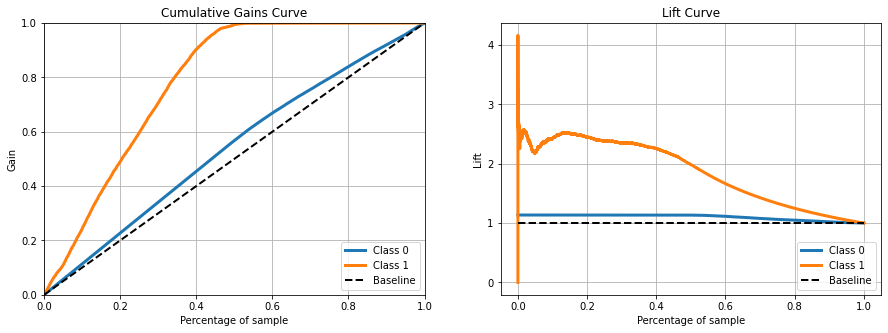

In [ ]:

fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, ax = axs[0])

# Lift
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax = axs[1]);

In [ ]:
# Performance
# compute precision at k
lr_precision_at_k = round(precision_at_k(df6, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Precision at K: {}'.format(lr_precision_at_k))

# compute Recall at k
lr_recall_at_k = round(recall_at_k(df6, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Recall at K: {}'.format(lr_recall_at_k))

LRegression Model - Precision at K: 0.272
LRegression Model - Recall at K: 0.898


#### 6.2.1 Logistic Regression - Cross Validation

In [ ]:
lr_cv  = cross_validation (df6, 5, 'LRegression CV', lr_model, x_train, y_train, 20000)


<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
lr_cv 

{'Model Name': 'LRegression CV',
 'Precision_at_k': '0.275 +/- 0.001',
 'Recall_at_k': '0.903 +/- 0.004'}

In [ ]:
rp_lr_cv = pd.DataFrame.from_dict(lr_cv, orient='index').T
rp_lr_cv

,Model Name,Precision_at_k,Recall_at_k
0,LRegression CV,0.275 +/- 0.001,0.903 +/- 0.004


### 6.3 Extra Trees Classifier

In [ ]:
# model definition
#et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
#et.fit( x_train, y_train )

# model prediction
#yhat_et = et.predict_proba( x_val )

In [ ]:
#fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
# Accumulative Gain
#skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax = axs[0])

# Lift
#skplt.metrics.plot_lift_curve(y_val, yhat_et, ax = axs[1]);

In [ ]:
# Performance

# compute precision at k
#et_precision_at_k = round(precision_at_k(df6, x_validation, y_validation, yhat_et, 25000), 3)
#print('ETrees Model - Precision at K: {}'.format(et_precision_at_k))

# compute Recall at k
#et_recall_at_k = round(recall_at_k(df6, x_validation, y_validation, yhat_et, 25000), 3)
#print('ETrees Model - Recall at K: {}'.format(et_recall_at_k))

#### 6.3.1 Extra Tress - Cross Validation

In [ ]:
#et_cv  = cross_validation (df6, 5, 'ETrees CV', et, x_train, y_train, 20000)

In [ ]:
#rp_et_cv = pd.DataFrame.from_dict(et_cv, orient='index').T

### 6.4 Random Forest

In [ ]:
# model definition
#rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
#rf.fit( x_train, y_train )

# model prediction
#yhat_rf = et.predict_proba( x_val )

In [ ]:

# Accumulative Gain
#fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
#skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax = axs[0])

# Lift
#skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax = axs[1]);

In [ ]:
# Performance

# compute precision at k
#rfc_precision_at_k = round(precision_at_k(, x_validation, y_validation, yhat_rf, 25000), 3)
#print('RFC Model - Precision at K: {}'.format(rfc_precision_at_k))

# compute Recall at k
##rfc_recall_at_k = round(recall_at_k(, x_validation, y_validation, yhat_rf, 25000), 3)
#print('RFC Model - Recall at K: {}'.format(rfc_recall_at_k))

#### 6.4.1 Random Forest - Cross Validation

In [ ]:
#rfc_cv  = cross_validation (, 5, 'RForest CV', rf, x_train, y_train, 20000)

In [ ]:
#rp_rfc_cv = pd.DataFrame.from_dict(rfc_cv, orient='index').T

### 6.5 XGBoost Classifier

In [ ]:
x_train

,annual_premium,vintage,age,region_code,vehicle_damage,policy_sales_channel,vehicle_damage,previously_insured
75625,0.663898,0.868512,0.353846,0.188286,0,0.212527,0,0
7415,-0.260028,0.352941,0.061538,0.082447,0,0.387389,0,1
295111,0.475517,0.833910,0.384615,0.077218,0,0.195955,0,1
201551,-0.707068,0.643599,0.461538,0.188286,1,0.195955,1,0
89216,1.752931,0.647059,0.076923,0.188286,1,0.212527,1,0
...,...,...,...,...,...,...,...,...
322232,2.610047,0.795848,0.384615,0.188286,0,0.195955,0,1
339832,-0.815497,0.948097,0.030769,0.100533,0,0.387389,0,1
12056,-0.795418,0.391003,0.046154,0.102169,0,0.387389,0,1
128635,-1.347053,0.141869,0.015385,0.085973,0,0.387389,0,0


In [ ]:
x_train = x_train.T.drop_duplicates().T
x_val = x_val.T.drop_duplicates().T

In [ ]:
x_val

,annual_premium,vintage,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
284980,0.423767,0.498270,0.400000,0.188286,1.0,0.195955,0.0
72057,0.009492,0.031142,0.076923,0.071837,0.0,0.387389,0.0
163907,-0.793866,0.100346,0.184615,0.188286,1.0,0.195955,0.0
347986,0.649660,0.698962,0.046154,0.077218,0.0,0.387389,1.0
16865,-0.869894,0.553633,0.507692,0.199822,0.0,0.212527,0.0
...,...,...,...,...,...,...,...
310236,-1.545200,0.837370,0.092308,0.118807,0.0,0.387389,1.0
312966,0.424679,0.512111,0.507692,0.129487,1.0,0.195955,0.0
169471,-0.705334,0.733564,0.430769,0.147444,1.0,0.000452,0.0
138741,-0.297996,0.245675,0.415385,0.188286,1.0,0.027069,0.0


In [ ]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error')

xgb_model.fit(x_train,y_train)

yhat_xgb = xgb_model.predict_proba(x_val)

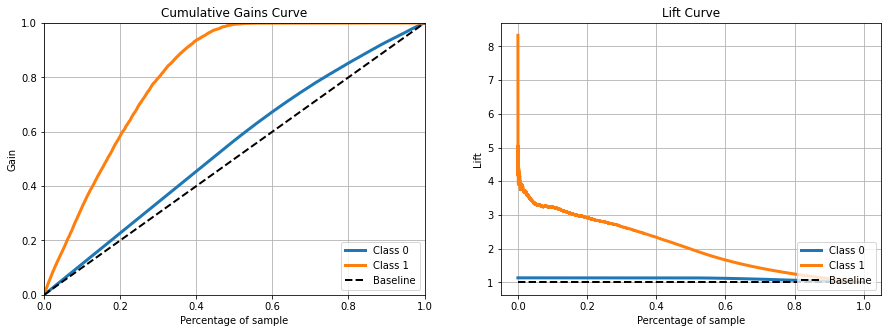

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax = axs[0])

# Left
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax = axs[1]);

In [ ]:
# Performance

# compute precision at k
xgb_precision_at_k = round(precision_at_k(df6, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Precision at K: {}'.format(xgb_precision_at_k))

# compute Recall at k
xgb_recall_at_k = round(recall_at_k(df6, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Recall at K: {}'.format(xgb_recall_at_k))

RFC Model - Precision at K: 0.283
RFC Model - Recall at K: 0.933


#### 6.5.1 XGBoost - Cross Validation

In [ ]:
xgb_cv  = cross_validation (df6, 5, 'XGB CV', xgb_model, x_train, y_train, 20000)

<ipython-input-122-6a9237e0e14e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold


In [ ]:
rp_xgb_cv = pd.DataFrame.from_dict(xgb_cv, orient='index').T

### 6.6 Model Selection

#### 6.6.1 Single Performance

In [ ]:
m_perf_dict = {
'Model Name'      : ['KNN', 'LRegression','XGB'],# 'Etrees', 'RForest', 'XGB'],
'Precision_at_k': [knn_precision_at_k, lr_precision_at_k, xgb_precision_at_k],#, et_precision_at_k, rfc_precision_at_k],
'Recall_at_k': [knn_recall_at_k, lr_recall_at_k, xgb_recall_at_k]}# et_recall_at_k, rfc_recall_at_k, xgb_recall_at_k]}

m_performance_sp = pd.DataFrame(m_perf_dict).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
m_performance_sp

,Model Name,Precision_at_k,Recall_at_k
0,XGB,0.283,0.933
1,LRegression,0.272,0.898
2,KNN,0.264,0.870


#### 6.6.2 Real Performance - Cross Validation

In [ ]:
#models_performance_cv = pd.concat([rp_knn_cv, rp_lr_cv, rp_et_cv, rp_rfc_cv, rp_xgb_cv]).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
models_performance_cv = pd.concat([rp_knn_cv, rp_lr_cv, rp_xgb_cv]).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
models_performance_cv


,Model Name,Precision_at_k,Recall_at_k
0,XGB CV,0.285 +/- 0.002,0.935 +/- 0.006
1,LRegression CV,0.275 +/- 0.001,0.903 +/- 0.004
2,KNN CV,0.218 +/- 0.001,0.894 +/- 0.004


## 7.0 Hyperparameter fine tuning

In [ ]:
df7 = df6.copy()

### 7.1 Random Search

In [ ]:
param = { 'objective'        : ['binary:logistic'],
          'eval_metric'      : ['error'],
          'n_estimators'     : [500, 750, 1000], 
          'eta'              : [0.01, 0.05, 0.09],
          'max_depth'        : [1, 5, 9],
          'subsample'        : [0.1, 0.5, 0.9],
          'colsample_bytree' : [0.1, 0.5, 0.9],
          'min_child_weight' : [3, 12, 20] 
        }

MAX_EVAL = 10

In [ ]:

final_result = pd.DataFrame({'Model Name':[], 'Precision_at_k': [], 'Recall_at_k': []})

In [ ]:
final_result

,Model Name,Precision_at_k,Recall_at_k


In [ ]:
# for i in range (MAX_EVAL):
#    hp = {w: random.sample(v, 1) [0] for w, v in param.items()}
#    print ('Step ' + str(i + 1) + '/' + str(MAX_EVAL))
#    print (hp)
     
#model_xgb = xgb.XGBClassifier(
#                 objective = hp['objective'],
#                 eval_metric = hp['eval_metric'],
#                 n_estimators = hp['n_estimators'], 
#                 eta = hp['eta'], 
#                 max_depth = hp['max_depth'], 
#                 subsample = hp['subsample'],
#                 colsample_bytree = hp['colsample_bytree'],
#                 min_child_weight = hp['min_child_weight'])
     
#result = cross_validation (df8, 5, 'XGBoost FT', model_xgb, x_train, y_train, 20000)
#result = pd.DataFrame.from_dict(result, orient='index').T
#final_result = pd.concat([final_result, result])
     
# final_result = pd.DataFrame(final_result)

In [ ]:
# final_result.reset_index(drop = True)


In [ ]:
# final_res = final_result.sort_values('Recall_at_k', ascending = False)
# final_res 

### 7.2 Final Model

In [ ]:

xgb_param_tuned = {'objective': 'binary:logistic', 
                   'eval_metric': 'error', 
                   'n_estimators': 750, 
                   'eta': 0.05, 
                   'max_depth': 5, 
                   'subsample': 0.5, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 20
                  }

In [ ]:
model_xgb_tuned = xgb.XGBClassifier (
    objective = xgb_param_tuned['objective'],
    eval_metric = xgb_param_tuned['eval_metric'],
    n_estimators = xgb_param_tuned['n_estimators'], 
    eta = xgb_param_tuned['eta'], 
    max_depth = xgb_param_tuned['max_depth'], 
    subsample = xgb_param_tuned['subsample'],
    colsample_bytree = xgb_param_tuned['colsample_bytree'],
    min_child_weight = xgb_param_tuned['min_child_weight'])

model_xgb_tuned.fit(x_train, y_train)

yhat_xgb_tuned = model_xgb_tuned.predict_proba(x_val)

In [ ]:
yhat_xgb_tuned.shape

(63090, 2)

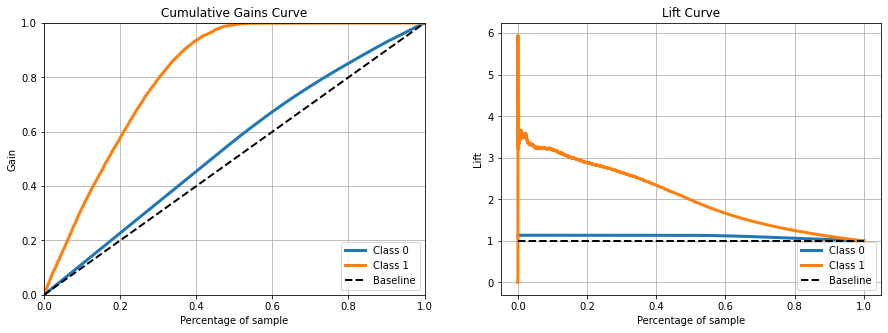

In [ ]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_tuned, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_tuned, ax = axs[1]);

In [ ]:
# Compute Recall at k
xgb_recall_at_20000 = round(recall_at_k(df7, x_validation, y_validation, yhat_xgb, 20000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))

XGB Model - Recall at K: 0.933


## 8.0 Error Interpretation

In [ ]:
df8 = df7.copy()

### 8.1 Machine Learning - Test Dataset

In [ ]:
# Test Dataset Extraction
X = df1.drop('response', axis = 1).copy()
y = df1['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df_test is a separate dataset, and will be used to perfomr the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

In [ ]:

df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
275163,275164,Female,24,1,41.0,1,< 1 Year,No,31696.0,152.0,62,0
228955,228956,Female,39,1,41.0,0,1-2 Year,Yes,34202.0,124.0,188,0
183986,183987,Female,25,1,39.0,0,< 1 Year,No,31140.0,152.0,200,0
272782,272783,Female,67,1,28.0,0,> 2 Years,Yes,2630.0,26.0,17,0
24900,24901,Male,23,1,46.0,1,< 1 Year,No,32159.0,152.0,149,0
...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,1,33.0,1,< 1 Year,No,32955.0,152.0,23,0
18930,18931,Male,49,1,40.0,0,> 2 Years,Yes,2630.0,124.0,277,0
135229,135230,Male,24,1,27.0,0,< 1 Year,No,26595.0,152.0,277,0
105049,105050,Male,22,1,29.0,1,< 1 Year,No,42844.0,152.0,140,0


#### Test preparation

In [ ]:
#load x_test and y_test from test data.
#x_test = pd.read_csv(datapath+'full_test_data.csv.csv', index_col=0)
x_test = df_test
y_test = x_test['response']
x_test = x_test.drop('response', axis=1)
x_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
275163,275164,Female,24,1,41.0,1,< 1 Year,No,31696.0,152.0,62
228955,228956,Female,39,1,41.0,0,1-2 Year,Yes,34202.0,124.0,188
183986,183987,Female,25,1,39.0,0,< 1 Year,No,31140.0,152.0,200
272782,272783,Female,67,1,28.0,0,> 2 Years,Yes,2630.0,26.0,17
24900,24901,Male,23,1,46.0,1,< 1 Year,No,32159.0,152.0,149
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,1,33.0,1,< 1 Year,No,32955.0,152.0,23
18930,18931,Male,49,1,40.0,0,> 2 Years,Yes,2630.0,124.0,277
135229,135230,Male,24,1,27.0,0,< 1 Year,No,26595.0,152.0,277
105049,105050,Male,22,1,29.0,1,< 1 Year,No,42844.0,152.0,140


In [ ]:
# ----- Feature Engeneering ----- 
# Vehicle Damage Number
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
x_test['vehicle_age'] =  x_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# ----- Data Preparation - Standardization ----- 
#health_annual_paid: StandardScaler
x_test['annual_premium'] = ss.transform(x_test[['annual_premium']].values)
    #If we used fit_transform() on our test data too, we would compute a new mean and variance, that is a new scale for each feature, and would let our model learn about our test data too. Using transform() we use the same mean and variance as it is calculated from our training data to transform our test data.

# ----- Data Preparation - Rescaling ----- 
#age: MinMaxScaler
x_test['age'] = mms_age.transform( x_test[['age']].values )
#days_associated: MinMaxScaler
x_test['vintage'] = mms_vintage.fit_transform( x_test[['vintage']].values )


# ----- Data Preparation - Encoding ----- 
#vehicle_age: one hot encoding 
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] ) 
#gender: target encoding
x_test.loc[:,'gender'] = x_test.loc[:,'gender'].map(target_encode_gender)
#region_code: target encoding
x_test.loc[:,'region_code'] = x_test.loc[:,'region_code'].map(target_encode_region_code)
#policy_sales_channel: frequency encoding
x_test.loc[:,'policy_sales_channel'] = x_test['policy_sales_channel'].map(fe_policy_sales_channel)

In [ ]:
x_test.shape

(76222, 13)

### 8.2 Business Performance

In [ ]:
# rounding the number of calls to 40000 to Compute Recall at k based on the validation dataset and previous yhat_xgb
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 40000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.999
Percentage of customers interested: 99.9%


#### 8.2.2 Percentage of clients interested in vehicle insurance that will be contacted with 20.000 calls.

In [ ]:
data = x_test.copy()
data['target'] = y_test.copy()
data.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,target
275163,275164,0.100393,0.061538,1,0.116297,1,0,-0.392369,0.387389,0.179931,1,0,0,0
228955,228956,0.100393,0.292308,1,0.116297,0,1,-0.163647,0.195955,0.615917,0,1,0,0
183986,183987,0.100393,0.076923,1,0.113402,0,0,-0.443115,0.387389,0.657439,1,0,0,0
272782,272783,0.100393,0.723077,1,0.188286,0,1,-3.045222,0.212527,0.024221,0,0,1,0
24900,24901,0.138716,0.046154,1,0.100533,1,0,-0.350111,0.387389,0.480969,1,0,0,0


In [ ]:
# getting the percentage provided by the algorithm based on test dataset
calls = 20000
total_leads = data.shape[0]

percent_at_20k = 20000 / len(data)
recall_at_20k, table_20k = precision_recall_at_k(data, k=20000)

perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

NameError: ignored

In [ ]:
round(20000 / data.shape[0]*100 )

26

In [ ]:
round(data.loc[data['target'] == 1].shape[0])

9342

In [ ]:
round(df1['annual_premium'].median())

31669

#### 8.2.3 And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing vehicle insurance will the sales team be able to contact?

In [ ]:
# getting the percentage provided by the algorithm based on test dataset
calls = 40000
total_leads = data.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 76222
% of calls: 52.48%


#### 8.2.4 Resultados:

* Há 76222 novos clientes, dos quais 9342 estão interessados (12.24% do total)

* O ticket médio para seguro de saúde é $31669.

* Com 20.000 ligações, podemos atingir 71,29% dos 9342 interessandos

* COm 40.000 ligações, podemos atingir 99,48% dos 9342 interessados

## 9.0 Performance Metrics

### 7.1 ROI 

In [ ]:
# results = pd.DataFrame()
# results['prediction'] = yhat_xgb_tuned[:,1].tolist()
# results['real'] = y_val.tolist()

# # ordering by prediction
# results = results.sort_values( 'prediction', ascending=False )

# # Percentage of intereset ( Propensity Score )
# results['real_cum'] = results['real'].cumsum() 
# results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# # Percentage of Base ( Clients )
# results['base'] = range( 1, len( results ) + 1  )
# results['base_cum_perc'] = 100*results['base']/len( results )

# # Baseline model
# results['baseline'] = results['base_cum_perc']

# # Lift Calculation
# results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

In [ ]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
7,0.70,0.720927,2,57.674174,2.883709,1.000000,54.790466
6,0.60,0.602071,45,1083.727348,2.408283,0.744638,1081.319065
5,0.50,0.500043,470,9400.816894,2.000174,0.531376,9398.816720
4,0.40,0.400000,3051,48816.026187,1.600001,0.354254,48814.426186
3,0.30,0.300027,7799,93596.557081,1.200110,0.212569,93595.356971
2,0.20,0.200016,8066,64533.323097,0.800066,0.106295,64532.523031
1,0.10,0.100015,6294,25179.667482,0.400058,0.035447,25179.267424
0,0.01,0.000057,37363,84.539694,0.000226,0.000020,84.539468


[Text(0.5, 1.0, 'ROI')]

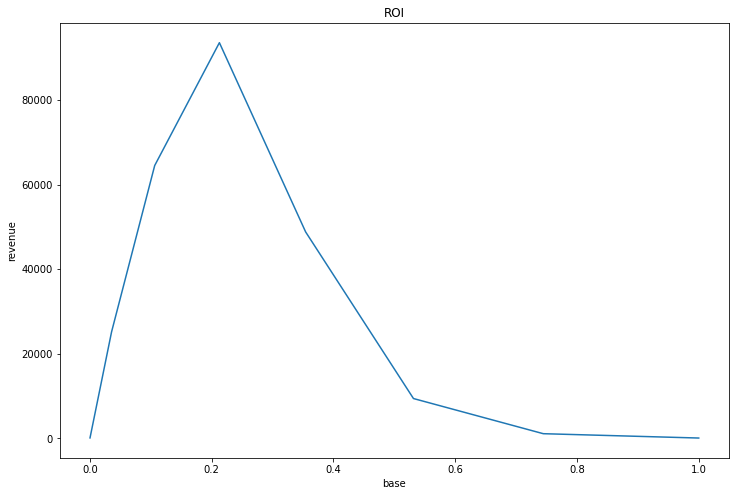

In [ ]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux ).set(title='ROI')

## 10. Conclusion

* Com base nos resultados dos negócios, a seguradora passa a ter uma vantagem competitiva sobre seus concorrentes, reduzindo o custo de aquisição de clientes e aumentando sua receita.

* A equipe de vendas pode focar sua atenção nos primeiros 20.000 ou 40.000 clientes da lista e, no futuro, focar nos primeiros K clientes da nova lista.

* Insights foram revelados e, com os resultados obtidos, é possível simular perfis de clientes, funcionalidade de grande valia para a empresa.